In [45]:
import os
from pprint import pprint
import torch
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIReader
from tiatoolbox.tools.patchextraction import get_patch_extractor
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt
import numpy as np
from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm
import cv2
import pickle
import skimage
import cv2
import skimage.measure
from torch.utils.data import DataLoader
import json
from multiprocessing import Pool
from tiatoolbox.annotation.storage import Annotation, SQLiteStore
from shapely import Point, Polygon

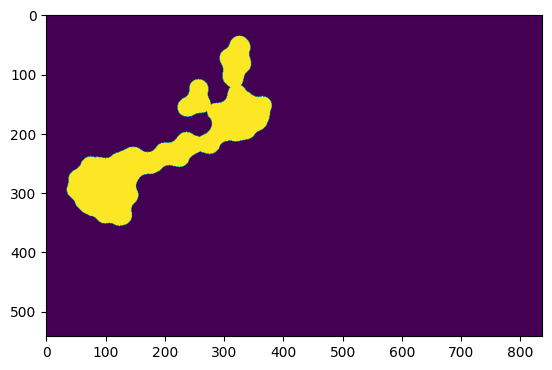

In [46]:
wsi_name = "106S.tif"
wsi_without_ext = os.path.splitext(wsi_name)[0]
masks_dir = "/home/u1910100/GitHub/TIAger-Torch/output/seg_out"
tumor_stroma_mask_path = os.path.join(masks_dir, f"{wsi_without_ext}_tumor_stroma.npy")

tumor_stroma_mask = np.load(tumor_stroma_mask_path)

plt.imshow(tumor_stroma_mask)
plt.show()

In [47]:
detModel1 = "/home/u1910100/GitHub/TIAger-Torch/runs/cell/fold_1/model_55.pth"
detModel2 = "/home/u1910100/GitHub/TIAger-Torch/runs/cell/fold_2/model_40.pth"
detModel3 = "/home/u1910100/GitHub/TIAger-Torch/runs/cell/fold_3/model_30.pth"
detModel = [detModel1, detModel2, detModel3]

models: list[torch.nn.Module] = []
for model_path in detModel:
    model = smp.Unet(
        encoder_name="efficientnet-b0",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
    )

    model.load_state_dict(torch.load(model_path))

    model.to("cuda")
    model.eval()
    models.append(model)

In [48]:
def imagenet_normalise(img: torch.tensor) -> torch.tensor:
    """Normalises input image to ImageNet mean and std"""

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    for i in range(3):
        img[:, i, :, :] = (img[:, i, :, :] - mean[i]) / std[i]

    return img


def mm2_to_px(mm2, mpp):
    return (mm2 * 1e6) / mpp**2


def dist_to_px(dist, mpp):
    dist_px = int(round(dist / mpp))
    return dist_px


def px_to_mm(px, mpp):
    return px * mpp / 1000


def px_to_um2(px, mpp):
    area_um2 = px * (mpp**2)
    return area_um2


def detections_in_tile(image_tile, det_models):
    patch_size = 128
    overlap = 28
    tile_reader = VirtualWSIReader(image_tile, power=20)

    patch_extractor = get_patch_extractor(
        input_img=tile_reader,
        method_name="slidingwindow",
        patch_size=(patch_size, patch_size),
        stride=(overlap, overlap),
        resolution=20,
        units="power",
    )

    predictions = []
    batch_size = 256

    dataloader = DataLoader(patch_extractor, batch_size=batch_size, shuffle=False)

    for i, imgs in enumerate(tqdm(dataloader, leave=False)):
        imgs = torch.permute(imgs, (0, 3, 1, 2))
        imgs = imgs / 255
        imgs = imagenet_normalise(imgs)
        imgs = imgs.to("cuda").float()

        val_predicts = np.zeros(shape=(imgs.size()[0], 128, 128), dtype=np.float32)

        with torch.no_grad():
            for det_model in det_models:
                temp_out = det_model(imgs)
                temp_out = torch.sigmoid(temp_out)
                temp_out = temp_out.detach().cpu().numpy()[:, 0, :, :]

                val_predicts += temp_out

        val_predicts = val_predicts / 3
        predictions.extend(list(val_predicts))

    return predictions, patch_extractor.coordinate_list


def tile_detection_stats(predictions, coordinate_list, x, y):
    tile_prediction = SemanticSegmentor.merge_prediction(
        (1024, 1024), predictions, coordinate_list
    )
    threshold = 0.99
    tile_prediction_mask = tile_prediction > threshold

    mask_label = skimage.measure.label(tile_prediction_mask)

    stats = skimage.measure.regionprops(mask_label, intensity_image=tile_prediction)
    output_points = []
    annotations = []
    for region in stats:
        centroid = np.round(region["centroid"]).astype(int)

        c, r, confidence = (
            np.round(centroid[1]),
            np.round(centroid[0]),
            region["mean_intensity"],
        )

        c1 = c + x
        r1 = r + y
        prediction_record = {
            "point": [
                float(px_to_mm(c1, 0.5)),
                float(px_to_mm(r1, 0.5)),
                float(0.5009999871253967),
            ],
            "probability": float(confidence),
        }

        output_points.append(prediction_record)
        annotations.append((int(c1), int(r1)))
    return annotations, output_points

In [49]:
wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images/"
wsi_path = os.path.join(wsi_dir, wsi_name)
wsi = WSIReader.open(wsi_path)

tile_extractor = get_patch_extractor(
    input_img=wsi,
    method_name="slidingwindow",
    patch_size=(1024, 1024),
    resolution=20,
    units="power",
    input_mask=tumor_stroma_mask,
)
# Each tile of size 1024x1024
annotations = []
output_dict = {
    "type": "Multiple points",
    "version": {"major": 1, "minor": 0},
    "points": [],
}

for i, tile in enumerate(tqdm(tile_extractor)):
    bounding_box = tile_extractor.coordinate_list[i]  # (x_start, y_start, x_end, y_end)
    predictions, coordinates = detections_in_tile(tile, models)
    annotations_tile, output_points_tile = tile_detection_stats(
        predictions, coordinates, bounding_box[0], bounding_box[1]
    )
    annotations.extend(annotations_tile)
    output_dict["points"].extend(output_points_tile)

output_path = (
    f"/home/u1910100/GitHub/TIAger-Torch/output/det_out/{wsi_without_ext}.json"
)
with open(output_path, "w") as fp:
    json.dump(output_dict, fp, indent=4)

output_path = (
    f"/home/u1910100/GitHub/TIAger-Torch/output/det_out/{wsi_without_ext}_points.json"
)
with open(output_path, "w") as fp:
    json.dump(annotations, fp, indent=4)

|2024-04-30|11:00:41.030| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-04-30|11:00:41.031| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


  0%|          | 0/170 [00:00<?, ?it/s]

|2024-04-30|11:00:41.076| [WARNING] Raw data is None.
|2024-04-30|11:00:41.076| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:00:45.473| [WARNING] Raw data is None.
|2024-04-30|11:00:45.474| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:00:49.540| [WARNING] Raw data is None.
|2024-04-30|11:00:49.541| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:00:53.588| [WARNING] Raw data is None.
|2024-04-30|11:00:53.589| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:00:57.640| [WARNING] Raw data is None.
|2024-04-30|11:00:57.641| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:01.672| [WARNING] Raw data is None.
|2024-04-30|11:01:01.673| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:05.717| [WARNING] Raw data is None.
|2024-04-30|11:01:05.717| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:09.775| [WARNING] Raw data is None.
|2024-04-30|11:01:09.775| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:13.833| [WARNING] Raw data is None.
|2024-04-30|11:01:13.833| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:17.909| [WARNING] Raw data is None.
|2024-04-30|11:01:17.910| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:21.958| [WARNING] Raw data is None.
|2024-04-30|11:01:21.959| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:25.907| [WARNING] Raw data is None.
|2024-04-30|11:01:25.907| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:29.905| [WARNING] Raw data is None.
|2024-04-30|11:01:29.906| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:33.902| [WARNING] Raw data is None.
|2024-04-30|11:01:33.903| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:37.934| [WARNING] Raw data is None.
|2024-04-30|11:01:37.934| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:41.971| [WARNING] Raw data is None.
|2024-04-30|11:01:41.972| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:46.037| [WARNING] Raw data is None.
|2024-04-30|11:01:46.037| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:50.100| [WARNING] Raw data is None.
|2024-04-30|11:01:50.100| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:54.136| [WARNING] Raw data is None.
|2024-04-30|11:01:54.136| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:01:58.188| [WARNING] Raw data is None.
|2024-04-30|11:01:58.189| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:02.270| [WARNING] Raw data is None.
|2024-04-30|11:02:02.271| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:06.310| [WARNING] Raw data is None.
|2024-04-30|11:02:06.311| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:10.316| [WARNING] Raw data is None.
|2024-04-30|11:02:10.317| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:14.373| [WARNING] Raw data is None.
|2024-04-30|11:02:14.374| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:18.414| [WARNING] Raw data is None.
|2024-04-30|11:02:18.415| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:22.481| [WARNING] Raw data is None.
|2024-04-30|11:02:22.482| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:26.524| [WARNING] Raw data is None.
|2024-04-30|11:02:26.524| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:30.575| [WARNING] Raw data is None.
|2024-04-30|11:02:30.576| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:34.645| [WARNING] Raw data is None.
|2024-04-30|11:02:34.645| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:38.706| [WARNING] Raw data is None.
|2024-04-30|11:02:38.706| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:42.748| [WARNING] Raw data is None.
|2024-04-30|11:02:42.748| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:46.797| [WARNING] Raw data is None.
|2024-04-30|11:02:46.798| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:50.835| [WARNING] Raw data is None.
|2024-04-30|11:02:50.835| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:54.885| [WARNING] Raw data is None.
|2024-04-30|11:02:54.885| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:02:58.942| [WARNING] Raw data is None.
|2024-04-30|11:02:58.942| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:03.008| [WARNING] Raw data is None.
|2024-04-30|11:03:03.008| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:07.056| [WARNING] Raw data is None.
|2024-04-30|11:03:07.056| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:11.115| [WARNING] Raw data is None.
|2024-04-30|11:03:11.116| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:15.170| [WARNING] Raw data is None.
|2024-04-30|11:03:15.171| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:19.220| [WARNING] Raw data is None.
|2024-04-30|11:03:19.221| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:23.245| [WARNING] Raw data is None.
|2024-04-30|11:03:23.246| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:27.259| [WARNING] Raw data is None.
|2024-04-30|11:03:27.259| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:31.307| [WARNING] Raw data is None.
|2024-04-30|11:03:31.308| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:35.349| [WARNING] Raw data is None.
|2024-04-30|11:03:35.350| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:39.407| [WARNING] Raw data is None.
|2024-04-30|11:03:39.407| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:43.450| [WARNING] Raw data is None.
|2024-04-30|11:03:43.450| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:47.486| [WARNING] Raw data is None.
|2024-04-30|11:03:47.486| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:51.543| [WARNING] Raw data is None.
|2024-04-30|11:03:51.544| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:55.604| [WARNING] Raw data is None.
|2024-04-30|11:03:55.605| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:03:59.669| [WARNING] Raw data is None.
|2024-04-30|11:03:59.669| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:03.722| [WARNING] Raw data is None.
|2024-04-30|11:04:03.722| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:07.766| [WARNING] Raw data is None.
|2024-04-30|11:04:07.767| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:11.820| [WARNING] Raw data is None.
|2024-04-30|11:04:11.820| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:15.862| [WARNING] Raw data is None.
|2024-04-30|11:04:15.863| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:19.914| [WARNING] Raw data is None.
|2024-04-30|11:04:19.914| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:23.988| [WARNING] Raw data is None.
|2024-04-30|11:04:23.989| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:28.038| [WARNING] Raw data is None.
|2024-04-30|11:04:28.038| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:32.093| [WARNING] Raw data is None.
|2024-04-30|11:04:32.093| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:36.136| [WARNING] Raw data is None.
|2024-04-30|11:04:36.137| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:40.199| [WARNING] Raw data is None.
|2024-04-30|11:04:40.199| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:44.283| [WARNING] Raw data is None.
|2024-04-30|11:04:44.283| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:48.313| [WARNING] Raw data is None.
|2024-04-30|11:04:48.314| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:52.363| [WARNING] Raw data is None.
|2024-04-30|11:04:52.364| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:04:56.380| [WARNING] Raw data is None.
|2024-04-30|11:04:56.381| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:00.421| [WARNING] Raw data is None.
|2024-04-30|11:05:00.421| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:04.495| [WARNING] Raw data is None.
|2024-04-30|11:05:04.496| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:08.532| [WARNING] Raw data is None.
|2024-04-30|11:05:08.533| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:12.588| [WARNING] Raw data is None.
|2024-04-30|11:05:12.588| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:16.645| [WARNING] Raw data is None.
|2024-04-30|11:05:16.645| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:20.702| [WARNING] Raw data is None.
|2024-04-30|11:05:20.703| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:24.785| [WARNING] Raw data is None.
|2024-04-30|11:05:24.785| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:28.838| [WARNING] Raw data is None.
|2024-04-30|11:05:28.839| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:32.895| [WARNING] Raw data is None.
|2024-04-30|11:05:32.896| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:36.957| [WARNING] Raw data is None.
|2024-04-30|11:05:36.958| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:40.998| [WARNING] Raw data is None.
|2024-04-30|11:05:40.999| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:45.067| [WARNING] Raw data is None.
|2024-04-30|11:05:45.068| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:49.118| [WARNING] Raw data is None.
|2024-04-30|11:05:49.119| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:53.167| [WARNING] Raw data is None.
|2024-04-30|11:05:53.168| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:05:57.232| [WARNING] Raw data is None.
|2024-04-30|11:05:57.232| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:01.280| [WARNING] Raw data is None.
|2024-04-30|11:06:01.281| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:05.365| [WARNING] Raw data is None.
|2024-04-30|11:06:05.366| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:09.438| [WARNING] Raw data is None.
|2024-04-30|11:06:09.438| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:13.483| [WARNING] Raw data is None.
|2024-04-30|11:06:13.484| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:17.536| [WARNING] Raw data is None.
|2024-04-30|11:06:17.537| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:21.586| [WARNING] Raw data is None.
|2024-04-30|11:06:21.586| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:25.657| [WARNING] Raw data is None.
|2024-04-30|11:06:25.658| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:29.740| [WARNING] Raw data is None.
|2024-04-30|11:06:29.741| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:33.780| [WARNING] Raw data is None.
|2024-04-30|11:06:33.780| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:37.841| [WARNING] Raw data is None.
|2024-04-30|11:06:37.841| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:41.885| [WARNING] Raw data is None.
|2024-04-30|11:06:41.886| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:45.953| [WARNING] Raw data is None.
|2024-04-30|11:06:45.954| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:50.018| [WARNING] Raw data is None.
|2024-04-30|11:06:50.018| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:54.060| [WARNING] Raw data is None.
|2024-04-30|11:06:54.060| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:06:58.094| [WARNING] Raw data is None.
|2024-04-30|11:06:58.095| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:02.141| [WARNING] Raw data is None.
|2024-04-30|11:07:02.142| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:06.179| [WARNING] Raw data is None.
|2024-04-30|11:07:06.180| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:10.239| [WARNING] Raw data is None.
|2024-04-30|11:07:10.239| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:14.283| [WARNING] Raw data is None.
|2024-04-30|11:07:14.283| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:18.339| [WARNING] Raw data is None.
|2024-04-30|11:07:18.339| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:22.372| [WARNING] Raw data is None.
|2024-04-30|11:07:22.373| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:26.427| [WARNING] Raw data is None.
|2024-04-30|11:07:26.427| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:30.511| [WARNING] Raw data is None.
|2024-04-30|11:07:30.511| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:34.554| [WARNING] Raw data is None.
|2024-04-30|11:07:34.555| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:38.591| [WARNING] Raw data is None.
|2024-04-30|11:07:38.592| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:42.709| [WARNING] Raw data is None.
|2024-04-30|11:07:42.709| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:46.791| [WARNING] Raw data is None.
|2024-04-30|11:07:46.791| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:50.820| [WARNING] Raw data is None.
|2024-04-30|11:07:50.820| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:54.896| [WARNING] Raw data is None.
|2024-04-30|11:07:54.896| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:07:58.940| [WARNING] Raw data is None.
|2024-04-30|11:07:58.941| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:02.991| [WARNING] Raw data is None.
|2024-04-30|11:08:02.991| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:07.027| [WARNING] Raw data is None.
|2024-04-30|11:08:07.027| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:11.059| [WARNING] Raw data is None.
|2024-04-30|11:08:11.060| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:15.088| [WARNING] Raw data is None.
|2024-04-30|11:08:15.089| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:19.118| [WARNING] Raw data is None.
|2024-04-30|11:08:19.118| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:23.152| [WARNING] Raw data is None.
|2024-04-30|11:08:23.153| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:27.190| [WARNING] Raw data is None.
|2024-04-30|11:08:27.191| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:31.265| [WARNING] Raw data is None.
|2024-04-30|11:08:31.267| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:35.403| [WARNING] Raw data is None.
|2024-04-30|11:08:35.403| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:39.463| [WARNING] Raw data is None.
|2024-04-30|11:08:39.463| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:43.553| [WARNING] Raw data is None.
|2024-04-30|11:08:43.553| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:47.607| [WARNING] Raw data is None.
|2024-04-30|11:08:47.607| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:51.649| [WARNING] Raw data is None.
|2024-04-30|11:08:51.649| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:55.707| [WARNING] Raw data is None.
|2024-04-30|11:08:55.707| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:08:59.800| [WARNING] Raw data is None.
|2024-04-30|11:08:59.800| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:03.840| [WARNING] Raw data is None.
|2024-04-30|11:09:03.841| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:07.907| [WARNING] Raw data is None.
|2024-04-30|11:09:07.907| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:11.942| [WARNING] Raw data is None.
|2024-04-30|11:09:11.942| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:15.967| [WARNING] Raw data is None.
|2024-04-30|11:09:15.968| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:20.050| [WARNING] Raw data is None.
|2024-04-30|11:09:20.051| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:24.128| [WARNING] Raw data is None.
|2024-04-30|11:09:24.129| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:28.188| [WARNING] Raw data is None.
|2024-04-30|11:09:28.189| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:32.234| [WARNING] Raw data is None.
|2024-04-30|11:09:32.234| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:36.293| [WARNING] Raw data is None.
|2024-04-30|11:09:36.293| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:40.392| [WARNING] Raw data is None.
|2024-04-30|11:09:40.393| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:44.490| [WARNING] Raw data is None.
|2024-04-30|11:09:44.491| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:48.582| [WARNING] Raw data is None.
|2024-04-30|11:09:48.583| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:52.647| [WARNING] Raw data is None.
|2024-04-30|11:09:52.647| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:09:56.724| [WARNING] Raw data is None.
|2024-04-30|11:09:56.724| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:00.777| [WARNING] Raw data is None.
|2024-04-30|11:10:00.778| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:04.893| [WARNING] Raw data is None.
|2024-04-30|11:10:04.893| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:08.988| [WARNING] Raw data is None.
|2024-04-30|11:10:08.988| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:13.064| [WARNING] Raw data is None.
|2024-04-30|11:10:13.065| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:17.166| [WARNING] Raw data is None.
|2024-04-30|11:10:17.167| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:21.278| [WARNING] Raw data is None.
|2024-04-30|11:10:21.279| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:25.371| [WARNING] Raw data is None.
|2024-04-30|11:10:25.371| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:29.444| [WARNING] Raw data is None.
|2024-04-30|11:10:29.444| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:33.519| [WARNING] Raw data is None.
|2024-04-30|11:10:33.519| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:37.592| [WARNING] Raw data is None.
|2024-04-30|11:10:37.592| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:41.660| [WARNING] Raw data is None.
|2024-04-30|11:10:41.660| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:45.786| [WARNING] Raw data is None.
|2024-04-30|11:10:45.786| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:49.882| [WARNING] Raw data is None.
|2024-04-30|11:10:49.882| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:53.995| [WARNING] Raw data is None.
|2024-04-30|11:10:53.996| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:10:58.123| [WARNING] Raw data is None.
|2024-04-30|11:10:58.124| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:02.192| [WARNING] Raw data is None.
|2024-04-30|11:11:02.193| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:06.258| [WARNING] Raw data is None.
|2024-04-30|11:11:06.258| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:10.328| [WARNING] Raw data is None.
|2024-04-30|11:11:10.328| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:14.399| [WARNING] Raw data is None.
|2024-04-30|11:11:14.399| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:18.467| [WARNING] Raw data is None.
|2024-04-30|11:11:18.467| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:22.538| [WARNING] Raw data is None.
|2024-04-30|11:11:22.538| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:26.585| [WARNING] Raw data is None.
|2024-04-30|11:11:26.585| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:30.625| [WARNING] Raw data is None.
|2024-04-30|11:11:30.626| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:34.679| [WARNING] Raw data is None.
|2024-04-30|11:11:34.679| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:38.740| [WARNING] Raw data is None.
|2024-04-30|11:11:38.740| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:42.784| [WARNING] Raw data is None.
|2024-04-30|11:11:42.785| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:46.806| [WARNING] Raw data is None.
|2024-04-30|11:11:46.807| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:50.893| [WARNING] Raw data is None.
|2024-04-30|11:11:50.893| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:54.982| [WARNING] Raw data is None.
|2024-04-30|11:11:54.982| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:11:59.028| [WARNING] Raw data is None.
|2024-04-30|11:11:59.029| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:12:03.081| [WARNING] Raw data is None.
|2024-04-30|11:12:03.082| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

|2024-04-30|11:12:07.128| [WARNING] Raw data is None.
|2024-04-30|11:12:07.128| [WARNING] Unknown scale (no objective_power or mpp)


  0%|          | 0/6 [00:00<?, ?it/s]

In [42]:
def point_to_box(x, y, size):
    """Convert centerpoint to bounding box of fixed size"""
    return np.array([x - size, y - size, x + size, y + size])


def get_centerpoints(box, dist):
    """Returns centerpoints of box"""
    return (box[0] + dist, box[1] + dist)


def non_max_suppression_fast(boxes, overlapThresh):
    """Very efficient NMS function taken from pyimagesearch"""

    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(
            idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
        )
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")


def slide_nms(slide_path, wsa_path, tile_size):
    """Iterate over WholeSlideAnnotation and perform NMS. For this to properly work, tiles need to be larger than model inference patches."""
    # Open WSI and detection points file
    wsi = WSIReader.open(slide_path)
    wsa = WholeSlideAnnotation(wsa_path)
    # Get base line WSI size
    shape = wsi.shapes[0]

    center_nms_points = []

    box_size = 8
    # get 2048x2048 patch coordinates without overlap
    for y_pos in range(0, shape[1], tile_size):
        for x_pos in range(0, shape[0], tile_size):
            # Select annotations within 2048x2048 box
            wsa_patch = wsa.select_annotations(
                int(x_pos + tile_size // 2),
                int(y_pos + tile_size // 2),
                tile_size,
                tile_size,
            )
            if wsa_patch:
                wsa_patch_coords = [point.coordinates for point in wsa_patch]
                if len(wsa_patch_coords) < 2:
                    continue

                # Convert each point to a 8x8 box
                boxes = np.array(
                    [point_to_box(x[0], x[1], box_size) for x in wsa_patch_coords]
                )
                nms_boxes = non_max_suppression_fast(boxes, 0.7)
                for box in nms_boxes:
                    center_nms_points.append(get_centerpoints(box, box_size))
    return center_nms_points


def points_to_annotation_store(points: list):
    """
    Args: points(list): list of (x,y) coordinates
    """
    annotation_store = SQLiteStore()

    for coord in points:
        annotation_store.append(
            Annotation(geometry=Point(coord[0], coord[1]), properties={"class": 1})
        )

    return annotation_store


def get_mask_area(mask_path, spacing=32):
    """Get the size of a mask in pixels where the mask is 1."""

    mask = np.load(mask_path)
    counts = np.unique(mask, return_counts=True)
    down = 6
    area = counts[1][1] * down**2
    return area


def create_til_score(cell_points_path, tumor_stroma_mask_path):
    with open(cell_points_path, "r") as fp:
        cell_points = json.load(fp)

    cell_counts = len(cell_points)
    print(cell_counts)

    til_area = dist_to_px(4, 0.5) ** 2
    print(til_area)
    tils_area = cell_counts * til_area

    stroma_area = get_mask_area(tumor_stroma_mask_path)
    tilscore = int((100 / int(stroma_area)) * int(tils_area))
    tilscore = min(100, tilscore)
    tilscore = max(0, tilscore)
    print(f"tilscore = {tilscore}")

In [15]:
cell_points_dir = "/home/u1910100/GitHub/TIAger-Torch/output/det_out"
cell_points_path = os.path.join(cell_points_dir, f"{wsi_without_ext}_points.json")
create_til_score(cell_points_path, tumor_stroma_mask_path)

2667
64
tilscore = 15


In [44]:
wsi_without_ext = "105S"
cell_points_dir = "/home/u1910100/GitHub/TIAger-Torch/output/det_out"
cell_points_path = os.path.join(cell_points_dir, f"{wsi_without_ext}_points.json")

with open(cell_points_path, "r") as fp:
    cell_points = json.load(fp)

print(cell_points[0])

store = points_to_annotation_store(cell_points)

for anno in store.values():
    print(anno)

box = Polygon(([0, 0], [0, 20], [20, 20], [20, 0], [0, 0]))
store.query(geometry=box, geometry_predicate="within")

[39719, 11286]
Annotation(POINT (39719 11286), {'class': 1})
Annotation(POINT (39412 11289), {'class': 1})
Annotation(POINT (39810 11300), {'class': 1})
Annotation(POINT (39833 11330), {'class': 1})
Annotation(POINT (39838 11330), {'class': 1})
Annotation(POINT (39337 11341), {'class': 1})
Annotation(POINT (39706 11360), {'class': 1})
Annotation(POINT (39884 11400), {'class': 1})
Annotation(POINT (39871 11411), {'class': 1})
Annotation(POINT (39566 11476), {'class': 1})
Annotation(POINT (39825 11520), {'class': 1})
Annotation(POINT (39511 11592), {'class': 1})
Annotation(POINT (38914 11636), {'class': 1})
Annotation(POINT (39395 11666), {'class': 1})
Annotation(POINT (39338 11779), {'class': 1})
Annotation(POINT (39750 11786), {'class': 1})
Annotation(POINT (39868 11784), {'class': 1})
Annotation(POINT (39816 11790), {'class': 1})
Annotation(POINT (39295 11800), {'class': 1})
Annotation(POINT (39282 11805), {'class': 1})
Annotation(POINT (39881 11806), {'class': 1})
Annotation(POINT (3

{}